<a href="https://colab.research.google.com/github/hyeonwooCH/Final_physiognomy_palmistry/blob/main/pupil_alg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class FaceParsingDataset(Dataset):
    def __init__(self, root_path, mode='test'):
        self.img_dir = os.path.join(root_path, mode, 'images')
        self.mask_dir = os.path.join(root_path, mode, 'masks')
        # 이미지 파일 목록 로드
        self.file_list = [f for f in sorted(os.listdir(self.img_dir)) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]

        # 파일명에서 확장자를 제외한 이름 추출 (예: '0174' -> '0174_grayscale.png')
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}_grayscale.png"

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        # 이미지 및 마스크 로드
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        # 텐서 변환: [C, H, W] 형태 및 0~1 정규화
        img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
        mask_np = np.array(mask)

        return img_tensor, mask_np, img_name

# 경로 설정 (실제 경로로 수정 필요)
BASE_PATH = '/content/drive/MyDrive/c. Final_Team/Split_dataset'
dataset = FaceParsingDataset(BASE_PATH, mode='test')
print(f"Dataset 로드 완료: {len(dataset)} 개의 파일을 찾았습니다.")

Dataset 로드 완료: 200 개의 파일을 찾았습니다.


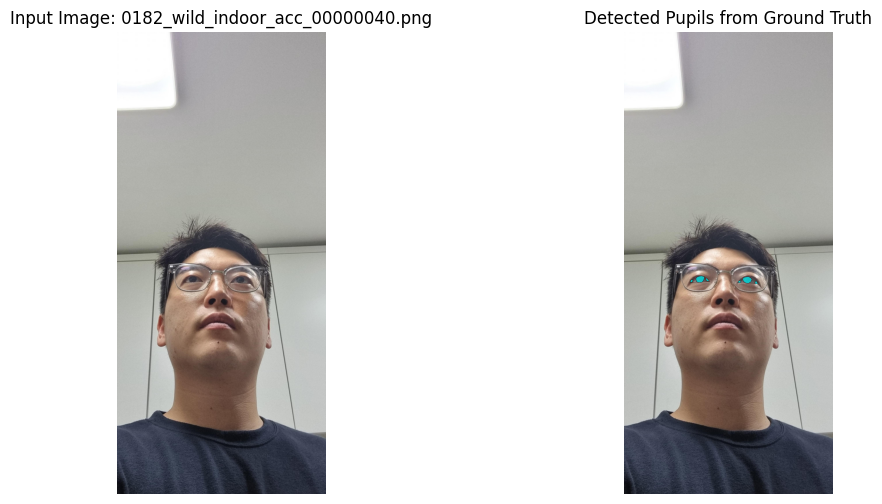

In [ ]:
import numpy as np
import cv2
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. 눈동자 검출 함수 (검은 부분을 꽉 채우는 로직)
def detect_pupils_natural_fixed(img_tensor, gt_mask):
    # 텐서를 넘파이로 변환
    img_np = (img_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    # 대비 강화 (눈동자 식별력 극대화)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced_gray = clahe.apply(gray)

    p_mask = np.zeros_like(gray)

    # [수정] 8: 왼쪽 눈, 9: 오른쪽 눈 영역만 타겟팅
    for eye_id in [4, 5]:
        mask_np = gt_mask.cpu().numpy() if torch.is_tensor(gt_mask) else gt_mask
        eye_area = (mask_np == eye_id).astype(np.uint8)

        if np.sum(eye_area) == 0: continue

        # 눈 영역 내 하위 35% 밝기를 임계값으로 설정 (더 넓게 잡기)
        eye_pixels = enhanced_gray[eye_area > 0]
        thresh_val = np.percentile(eye_pixels, 35)

        _, p_bin = cv2.threshold(enhanced_gray, thresh_val, 255, cv2.THRESH_BINARY_INV)
        p_mask_single = cv2.bitwise_and(p_bin, p_bin, mask=eye_area)

        # 팽창 연산으로 눈동자 영역 확장 (한 픽셀 더 두껍게)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        p_mask_single = cv2.dilate(p_mask_single, kernel, iterations=1)

        # Convex Hull로 실제 형태를 살리며 자연스럽게 보정
        contours, _ = cv2.findContours(p_mask_single, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) > 15:
                hull = cv2.convexHull(cnt)
                cv2.drawContours(p_mask, [hull], -1, 255, -1)

    return img_np, p_mask

# 2. 실행 및 시각화
try:
    # 샘플 로드 (dataset이 정의되어 있어야 함)
    idx = random.randint(0, len(dataset) - 1)
    test_img, test_mask, fname = dataset[idx]

    # 함수 호출
    img_raw, p_detected = detect_pupils_natural_fixed(test_img, test_mask)

    # 결과 출력
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_raw)
    plt.title(f"Input Image: {fname}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_raw)

    # 0은 투명, 1은 하늘색(Cyan)으로 눈동자만 표시
    overlay_cmap = mcolors.ListedColormap([(0,0,0,0), 'cyan'])
    plt.imshow(p_detected, cmap=overlay_cmap, alpha=0.7)
    plt.title("Detected Pupils from Ground Truth")
    plt.axis('off')

    plt.show()

except NameError:
    print("에러: 'dataset' 변수가 정의되지 않았습니다.")

segface로드

In [ ]:
# 코랩 셀에 이 코드 붙이기
import os
import cv2
from PIL import Image, ImageOps
import subprocess

# 원본 이미지 경로
input_image_path = "/content/test_images/input_sample.jpg"

# EXIF 회전 처리된 이미지 저장할 임시 경로
fixed_image_path = "/content/fixed_image_temp.jpg"

# 1단계: EXIF 처리
img = Image.open(input_image_path)
img = ImageOps.exif_transpose(img)  # ★ 회전 적용
img.save(fixed_image_path)

print("✅ EXIF 처리 + 추론 완료!")


FileNotFoundError: [Errno 2] No such file or directory: '/content/face-parsing'

In [ ]:
# 1. SegFace 저장소 클론 및 이동
!git clone https://github.com/Kartik-3004/SegFace.git
%cd SegFace

# 2. 필수 라이브러리 설치 (코랩 환경 최적화 버전)
!pip install -q timm==0.9.12 segmentation-models-pytorch albumentations python-dotenv huggingface_hub

Cloning into 'SegFace'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 147 (delta 53), reused 83 (delta 19), pack-reused 0 (from 0)
Receiving objects: 100% (147/147), 7.26 MiB | 16.27 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/SegFace
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.6 MB/s eta 0:00:00


In [ ]:
import os
from huggingface_hub import hf_hub_download

# 1. .env 경로 설정 파일 생성
root_path = "/content/SegFace"
with open(".env", "w") as f:
    f.write(f"ROOT_PATH={root_path}\n")
    f.write(f"DATA_PATH={root_path}/data\n")
    f.write(f"LOG_PATH={root_path}/logs\n")

# 2. 가중치(Weights) 다운로드
hf_hub_download(repo_id="kartiknarayan/SegFace",
                filename="convnext_celeba_512/model_299.pt",
                local_dir="./weights")

print("✅ 환경 설정 및 가중치 다운로드 완료!")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


convnext_celeba_512/model_299.pt:   0%|          | 0.00/1.10G [00:00<?, ?B/s]

✅ 환경 설정 및 가중치 다운로드 완료!


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import sys
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# 프로젝트 모듈 임포트 경로 추가
if '/content/SegFace' not in sys.path:
    sys.path.append('/content/SegFace')
from network.models.segface_celeb import SegFaceCeleb

# --- [설정 영역] ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/content/SegFace/weights/convnext_celeba_512/model_299.pt"
input_res = 512

# 테스트할 데이터 경로 (본인의 경로로 수정하세요)
# 예: /content/drive/MyDrive/test_data/images
test_images_path = "/content/drive/MyDrive/c. Final_Team/Split_dataset/test/images"
test_masks_path = "/content/drive/MyDrive/c. Final_Team/Split_dataset/test/masks"

# 수정된 class_names (SegFace 모델 출력 순서)
class_names = [
    'bg', 'neck', 'face', 'cloth', 'lr', 'rr', 'lb', 'rb', 'le',
    're', 'nose', 'imouth', 'llip', 'ulip', 'hair',
    'glass', 'hat', 'earr', 'neckl'
]
# ------------------



AI_HUB_TO_SEGFACE =  {
    0: 0, 1: 2, 2: 7, 3: 6, 4: 9, 5: 8, 6: 15, 7: 5, 8: 4, 9: 17,
    10: 10, 11: 11, 12: 13, 13: 12, 14: 1, 15: 18, 16: 3, 17: 14, 18: 16,
}

# 1. 모델 로드 함수
def load_segface_model():
    model = SegFaceCeleb(input_res, "convnext_base")
    checkpoint = torch.load(model_path, map_location=device)
    pretrained_dict = checkpoint.get('state_dict_backbone', checkpoint.get('model_state_dict', checkpoint))
    model.load_state_dict(pretrained_dict, strict=False)
    model.to(device)
    model.eval()
    return model

# 2. 다중 데이터 로더 클래스
class SegFaceEvalDataset(Dataset):
    def __init__(self, img_dir, mask_dir, res=512):
        import glob
        import os
        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.*")))
        self.mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.*")))
        self.res = res
    def __len__(self): return len(self.img_paths)

    def align_aihub_labels(self, mask_np):
        """AI 허브 ID를 SegFace ID로 재배열"""
        new_mask = np.zeros_like(mask_np)
        for ai_id, seg_id in AI_HUB_TO_SEGFACE.items():
            new_mask[mask_np == ai_id] = seg_id
        return new_mask

    def __getitem__(self, idx):
        # 1. 이미지 로드
        img = Image.open(self.img_paths[idx]).convert('RGB').resize((self.res, self.res))
        img_tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float().div(255)

        # 2. 마스크 로드 (AI 허브 Grayscale 대응)
        mask = Image.open(self.mask_paths[idx]).convert('L')
        mask = mask.resize((self.res, self.res), Image.NEAREST)
        mask_np = np.array(mask).astype(np.int64)

        # 💡 [핵심] AI 허브 데이터 전처리
        # 만약 AI 허브 데이터가 0, 1, 2... 순서가 아니라
        # 시각화를 위해 큰 값(예: 10, 20...)을 가지고 있다면 정규화가 필요합니다.
        # 고유값을 확인한 후 아래 주석을 해제하여 사용하세요.
        mask_np = self.align_aihub_labels(mask_np)

        mask_tensor = torch.from_numpy(mask_np).long()
        return img_tensor, mask_tensor, os.path.basename(self.img_paths[idx])



In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image

def process_new_input(image_path, model, device, res=512):
    # 1. 이미지 로드 및 전처리
    orig_img = Image.open(image_path).convert('RGB')
    img_resized = orig_img.resize((res, res))

    # [B, C, H, W] 형태로 변환
    img_tensor = torch.from_numpy(np.array(img_resized)).permute(2, 0, 1).float().div(255).unsqueeze(0).to(device)

    # 2. SegFace 추론 (forward 에러 해결)
    model.eval()
    with torch.no_grad():
        # [수정 포인트] SegFace forward는 (img, labels, dataset)을 요구함
        # 추론 시에는 labels와 dataset에 None이나 임의의 값을 전달
        output = model(img_tensor, labels=None, dataset=None)

        # 모델 출력 구조 대응 (일반적으로 0번 인덱스가 최종 로짓)
        if isinstance(output, (list, tuple)):
            output = output[0]

        pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    # 3. 눈동자 정밀 추출 로직
    img_np = (img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    enhanced_gray = clahe.apply(gray)

    pupil_mask = np.zeros_like(gray)

    # 8(le), 9(re) 영역 타겟팅
    for eye_id in [8, 9]:
        eye_area = (pred_mask == eye_id).astype(np.uint8)
        if np.sum(eye_area) == 0: continue

        eye_pixels = enhanced_gray[eye_area > 0]
        thresh_val = np.percentile(eye_pixels, 35)

        _, p_bin = cv2.threshold(enhanced_gray, thresh_val, 255, cv2.THRESH_BINARY_INV)
        p_mask_single = cv2.bitwise_and(p_bin, p_bin, mask=eye_area)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        p_mask_single = cv2.dilate(p_mask_single, kernel, iterations=1)

        contours, _ = cv2.findContours(p_mask_single, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            if cv2.contourArea(cnt) > 15:
                hull = cv2.convexHull(cnt)
                cv2.drawContours(pupil_mask, [hull], -1, 255, -1)

    return img_np, pred_mask, pupil_mask

# --- 실행 코드 ---
sample_image = '/content/test_images/fixed_image_temp.jpg'
# sample_image 경로가 올바른지 확인 후 실행하세요.
img_raw, p_mask, pupil_final = process_new_input(sample_image, model, device)

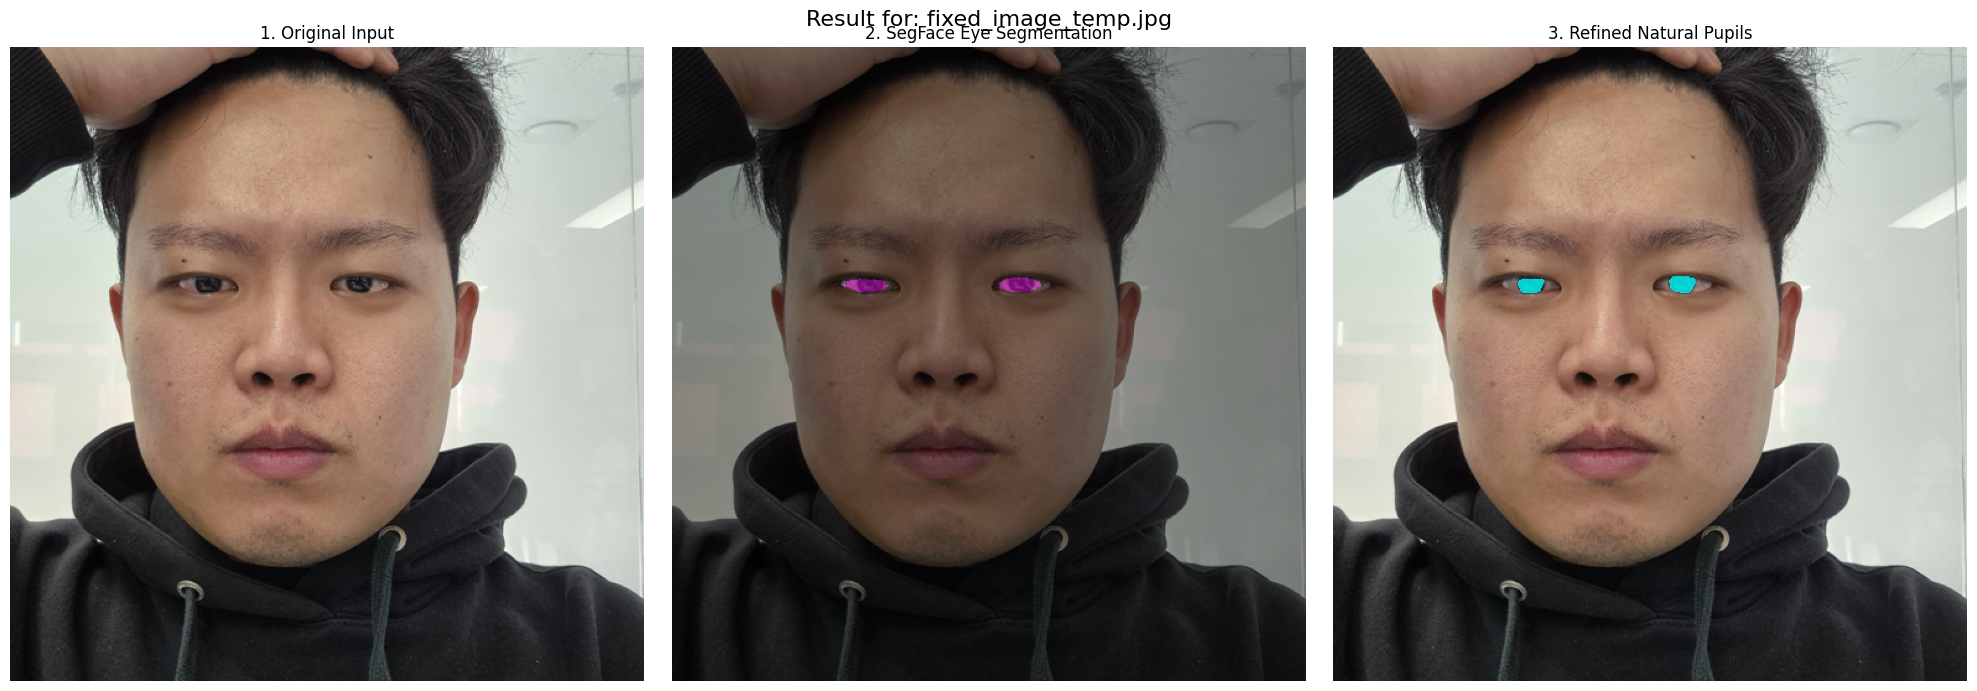

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def visualize_pupil_results(img_raw, pred_mask, pupil_final, title="Detection Result"):
    """
    img_raw: 전처리된 원본 이미지 (Numpy)
    pred_mask: SegFace가 예측한 전체 마스크
    pupil_final: 최종 정밀 추출된 눈동자 마스크
    """
    plt.figure(figsize=(20, 7))

    # 1. 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(img_raw)
    plt.title("1. Original Input")
    plt.axis('off')

    # 2. SegFace 눈 영역 (Step 1)
    # 8(왼쪽 눈), 9(오른쪽 눈) 영역을 분홍색 계열로 표시
    plt.subplot(1, 3, 2)
    plt.imshow(img_raw)
    eye_area = np.isin(pred_mask, [8, 9])

    # 눈 영역만 강조하기 위한 마스크 생성
    eye_overlay = np.zeros_like(img_raw, dtype=np.uint8)
    eye_overlay[eye_area] = [255, 0, 255] # Magenta 색상

    plt.imshow(eye_overlay, alpha=0.4) # 투명도 0.4로 겹치기
    plt.title("2. SegFace Eye Segmentation")
    plt.axis('off')

    # 3. 정밀 추출된 눈동자 (Step 2)
    # 최종 결과물인 pupil_final을 하늘색(Cyan)으로 강조
    plt.subplot(1, 3, 3)
    plt.imshow(img_raw)

    # 0번(배경)은 투명하게, 1번(눈동자)은 Cyan색으로 설정
    pupil_cmap = mcolors.ListedColormap([(0,0,0,0), 'cyan'])
    plt.imshow(pupil_final, cmap=pupil_cmap, alpha=0.8)

    plt.title("3. Refined Natural Pupils")
    plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# --- 실행부 ---
# 앞서 실행한 process_new_input의 결과값을 그대로 넣으시면 됩니다.
visualize_pupil_results(img_raw, p_mask, pupil_final, title=f"Result for: {os.path.basename(sample_image)}")